In [1]:
# ! pip install xgboost

In [2]:
import pyspark
import numpy as np
import xgboost

In [3]:
# Initialize pyspark

from pyspark.sql import SparkSession

spark = SparkSession.builder \
                    .master('local[*]')\
                    .appName("LightFM Features") \
                    .getOrCreate()

In [4]:
# Load train and metadata dataframes

path_to_df = 'gs://thesis_apc_bucket/df_data2'

df_data = spark.read.orc(path_to_df + '/df_train.orc')
df_playlists_metadata = spark.read.orc(path_to_df + '/df_playlists_metadata.orc')
df_test_playlists_metadata = spark.read.orc(path_to_df + '/df_test_metadata.orc')
df_tracks = spark.read.orc(path_to_df + '/df_tracks.orc')

In [5]:
# Index album and artist URI's

from pyspark.ml.feature import StringIndexer

album_indexer = StringIndexer(inputCol='album_uri', outputCol='album')
artist_indexer = StringIndexer(inputCol='artist_uri', outputCol='artist')

df_tracks = album_indexer.fit(df_tracks).transform(df_tracks)
df_tracks = artist_indexer.fit(df_tracks).transform(df_tracks)

In [6]:
# Load candidates

import pandas as pd

df_train = spark.read.orc(path_to_df + '/ii_candidate.orc')
df_val = spark.read.orc(path_to_df + '/iii_candidate.orc')
df_test = spark.read.orc(path_to_df + '/test_candidate.orc')

In [7]:
# Load holdout dataframes

df_train_holdouts = spark.read.orc(path_to_df + '/df_val1.orc')
df_val_holdouts = spark.read.orc(path_to_df + '/df_val2.orc')

In [8]:
# Add num_holdouts column to test metadata dataframe

from pyspark.sql.functions import col

df_test_playlists_metadata = df_test_playlists_metadata.withColumn('num_holdouts', col('num_tracks') - col('num_samples'))

In [10]:
# Find lengths for each set

train_length = df_train_holdouts.toPandas().groupby('pid').tid.nunique()
val_length = df_val_holdouts.toPandas().groupby('pid').tid.nunique()
test_length = df_test_playlists_metadata.toPandas().set_index('pid').num_holdouts

In [31]:
data = df_data.toPandas()
tracks_info = df_tracks.toPandas()

In [32]:
def create_count(df):
    
    tid_count = data.tid.value_counts()
    pid_count = data.pid.value_counts()

    df['tid_count'] = df.tid.map(tid_count).fillna(0)
    df['pid_count'] = df.pid.map(pid_count).fillna(0)
    
    album_count = data.tid.map(tracks_info.album).value_counts()
    artist_count = data.tid.map(tracks_info.artist).value_counts()
    
    df['album_count'] = df.tid.map(tracks_info.album).map(album_count).fillna(0)
    df['artist_count'] = df.tid.map(tracks_info.artist).map(artist_count).fillna(0)

In [33]:
def isin(i, j):
    if j is not np.nan:
        return i in j
    return False

def isin_sum(i, j):
    if j is not np.nan:
        return (i == j).sum()
    return 0

In [34]:
def create_artist_features(df):
    
    data_short = data[data.pid.isin(df.pid)]
    pid_artist = data_short.tid.map(tracks_info.artist).groupby(data_short.pid).apply(np.array)
    df_playlist = df.pid.map(pid_artist)
    df_artist = df.tid.map(tracks_info.artist)
    
    share_unique = pid_artist.apply(np.unique).apply(len) / pid_artist.apply(len)
    
    df['share_of_unique_artist'] = df.pid.map(share_unique).fillna(-1)
    df['sim_artist_in_playlist'] = [isin_sum(i, j) for i, j in zip(df_artist, df_playlist)]
    df['mean_artist_in_playlist'] = (df['sim_artist_in_playlist'] / df.pid.map(pid_artist.apply(len))).fillna(-1)

In [35]:
def create_album_features(df):
    
    data_short = data[data.pid.isin(df.pid)]
    pid_album = data_short.tid.map(tracks_info.album).groupby(data_short.pid).apply(np.array)
    df_playlist = df.pid.map(pid_album)
    df_album = df.tid.map(tracks_info.album)
    
    share_unique = pid_album.apply(np.unique).apply(len) / pid_album.apply(len)
    
    df['share_of_unique_album'] = df.pid.map(share_unique).fillna(-1)
    df['sim_album_in_playlist'] = [isin_sum(i, j) for i, j in zip(df_album, df_playlist)]
    df['mean_album_in_playlist'] = (df['sim_album_in_playlist'] / df.pid.map(pid_album.apply(len))).fillna(-1)


In [36]:
def create_features(df, df_length):
    df = df.toPandas()
    create_count(df)
    create_artist_features(df)
    create_album_features(df)
    df['tracks_holdout'] = df.pid.map(df_length)
    df = spark.createDataFrame(df)
    return df

In [ ]:
%%time

# Generate features for each candidate set

df_train = create_features(df_train, train_length)
df_val = create_features(df_val, val_length)
df_test = create_features(df_test, test_length)

CPU times: user 4min 54s, sys: 18.4 s, total: 5min 12s
Wall time: 5min 16s


In [ ]:
# Load features

train_co = spark.read.orc(path_to_df + '/ii_co_occurrence_features.orc').drop('target')
val_co = spark.read.orc(path_to_df + '/iii_co_occurrence_features.orc').drop('target')
test_co = spark.read.orc(path_to_df + '/test_co_occurrence_features.orc')

train_lightfm = spark.read.orc(path_to_df + '/ii_lightfm_features.orc').drop('target')
val_lightfm = spark.read.orc(path_to_df + '/iii_lightfm_features.orc').drop('target')
test_lightfm = spark.read.orc(path_to_df + '/test_lightfm_features.orc')

In [ ]:
# Join features to corresponding dataframes

df_train = df_train.join(train_co, ['pid', 'tid'])\
                   .join(train_lightfm, ['pid', 'tid'])
df_val = df_val.join(val_co, ['pid', 'tid'])\
               .join(val_lightfm, ['pid', 'tid'])
df_test = df_test.join(test_co, ['pid', 'tid'])\
                 .join(test_lightfm, ['pid', 'tid'])

In [ ]:
train = df_train.toPandas()

In [ ]:
xgtrain = xgboost.DMatrix(train.drop(['pid', 'tid', 'target'], axis=1), train.target)

In [ ]:
val = df_val.toPandas()

In [ ]:
xgval = xgboost.DMatrix(val.drop(['pid', 'tid', 'target'], axis=1), val.target)

In [ ]:
test = df_test.toPandas()

In [30]:
xgtest = xgboost.DMatrix(test.drop(['pid', 'tid'], axis=1))

In [40]:
%%time

# Train XGBoost model

results = {}

params = {
    'objective':'binary:logistic',
    'eta':0.1,
    'booster':'gbtree',
    'max_depth':7,
    'nthread':16,
    'seed':1,
    'eval_metric':'auc',
}

model = xgboost.train(
    params=list(params.items()),
    early_stopping_rounds=30, 
    verbose_eval=10, 
    dtrain=xgtrain,
    evals=[(xgtrain, 'train'), (xgval, 'test')],
    evals_result=results,
    num_boost_round=300,
)

[0]	train-auc:0.76602	test-auc:0.76144
[10]	train-auc:0.77745	test-auc:0.77225
[20]	train-auc:0.77844	test-auc:0.77293
[30]	train-auc:0.77965	test-auc:0.77314
[40]	train-auc:0.78165	test-auc:0.77163
[50]	train-auc:0.78535	test-auc:0.76915
[54]	train-auc:0.78719	test-auc:0.76767
CPU times: user 2h 11min 58s, sys: 4.41 s, total: 2h 12min 2s
Wall time: 18min 16s


In [41]:
# Save model

import joblib

path_to_models = 'models2'
# joblib.dump(model, path_to_models + '/xgboost-ps1.pkl')
model.save_model(path_to_models + '/xgboost-ps1.pkl')

In [34]:
score = model.predict(xgval)
val['score'] = score

In [35]:
scores = []
for pid, df, in val.sort_values('score', ascending=False).groupby('pid'):
    n = val_length[pid]
    scores.append(df[:n].target.sum() / n)
np.mean(scores)

0.08985909051319793

In [36]:
test['score'] = model.predict(xgtest)
test = test.sort_values(['pid', 'score'], ascending=[True, False])
recs = test.groupby('pid').tid.apply(lambda x: x.values[:500])
tracks_info = df_tracks.toPandas()
track_uri = tracks_info.track_uri 

In [37]:
submission = open('submission-ps1.csv', 'w')
submission.write('team_info,main,Exin,martin.alinggajaya@gmail.com\n')

for pid, tids in recs.items():
    submission.write('{}, '.format(pid) + ', '.join(track_uri.loc[tids].values) + '\n')
    
submission.close()

In [43]:
# Visualization

epochs = len(results['train']['auc'])
epochs

56

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

xgboost_results = pd.DataFrame(zip(results['train']['auc'], results['test']['auc']), columns=['train', 'test'])
# xgboost_results.index.name = 'epoch'
# xgboost_results = xgboost_results.reset_index()


[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'AUC')]

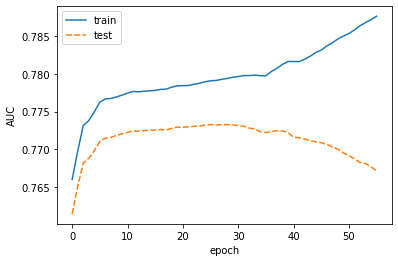

In [55]:
ax = sns.lineplot(data=xgboost_results)
ax.set(xlabel='epoch', ylabel='AUC')

In [58]:
# Feature importance based on gain

feature_gain = model.get_score(importance_type='gain')
sorted_feature_gain = {k: v for k, v in sorted(feature_gain.items(), key=lambda x: x[1], reverse=True)}
sorted_feature_gain

{'lightfm_rank': 1238.1101418825915,
 'co_occurrence_norm_mean': 1053.5777942915358,
 'co_occurrence_norm_max': 778.3996257231034,
 'lightfm_dot_product_text': 252.2121971296688,
 'tracks_holdout': 224.78487323772012,
 'lightfm_rank_text': 215.36311327343,
 'co_occurrence_norm_median': 205.40436907346944,
 'co_occurrence_mean': 182.67621112956363,
 'co_occurrence_median': 129.23802272931817,
 'co_occurrence_max': 119.08369811246347,
 'lightfm_dot_product': 110.65282576022726,
 'mean_artist_in_playlist': 90.49210288491737,
 'co_occurrence_norm_min': 73.50669097130432,
 'sim_artist_in_playlist': 68.34599651936368,
 'tid_bias': 66.15819757774511,
 'artist_count': 64.3892112303165,
 'share_of_unique_album': 59.13493134189541,
 'pid_bias': 48.59869837043823,
 'lightfm_prediction': 46.817611420888866,
 'co_occurrence_min': 44.894549774716985,
 'share_of_unique_artist': 43.15823708891753,
 'mean_album_in_playlist': 37.23956049192489,
 'tid_bias_text': 36.1714219196,
 'pid_count': 35.695742621

In [53]:
# Save train, val, and test

train.to_hdf('df_data2/train_final.hdf', key='abc')
val.to_hdf('df_data2/val_final.hdf', key='abc')
test.to_hdf('df_data2/test_final.hdf', key='abc')